# Deep Learning Project 2021/2022

*  **Cartier van Dissel Mauritz, mat. 222954**
*  **Tezza Davide, mat. 223546**



# Introduction

In this project for the course Deep Learning 2021/2022 we design and implement a technique of **Unsupervised Domain Aligment**. \\
The term refers to an **object recognition** task where some of our input data have no labels and where the **domain shift** between the data distributions is solved. \\

## The dataset

The considered dataset is **Adaptiope**, all the info can be found [here](https://openaccess.thecvf.com/content/WACV2021/papers/Ringwald_Adaptiope_A_Modern_Benchmark_for_Unsupervised_Domain_Adaptation_WACV_2021_paper.pdf).  
In particular, this dataset is composed of 3 types of images: Real Life images, Product images and Synthetic images. To the scope of this project we will focus only on *Real Life* images and *Product* images. From this domains, we will extract a subset of only 20 objects. \\
The chosen objects are:  

*   backpack
*   bookcase
*   car jack
*   comb
*   crown
*   file cabinet
*   flat iron
*   game controller
*   glasses
*   helicopter
*   ice skates
*   letter tray
*   monitor
*   mug
*   network switch
*   over-ear headphones
*   pen
*   purse
*   stand mixer
*   stroller

The purpose of this project is to perform Unsupervised Object Recognition on a given unlabeled target domain.  
In order to do this, we will have to simultaneously train a Supervised Object Recognition network on a source domain and train a Domain Alignment technique that translates the features to the target domain. This will permit to account for the domain difference between the source and the target.

Summarizing everything, we want to classify correctly the objects present in the product domain, knowing the correct classification of the images present in the real life dataset

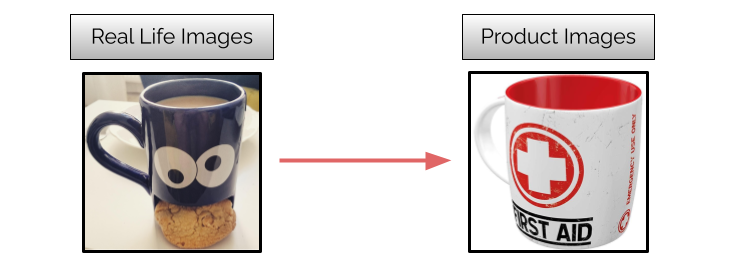

and viceversa we want to classify the Real Life images starting from the labeled Product images.

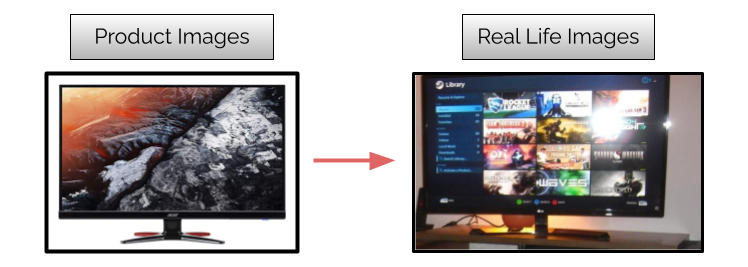

To this scope we will divide both Real Life and Product domains into training and validation sets, with a standard 80% - 20% split.

## The model architecture

At the beginning of our implementation we started by designing an architecture similar to the one we have seen during the laboratory. It was composed by *4 convolutional layers* followed by *3 fully connected layers*. To each layer we added a *batch normalization* for both source and target. \\
This structure was too simple and the overall results were disappointing. In fact we didn't manage to get an accuracy higher than 23% in the direction  *Product -> Real Life*, even by tuning all the parameters.  

At that point we began to look for something more complex and we read different papers and thought about different possibilities. 

It seemed that the convolutions weren't able to capture the important features well enough. Therefore, we decided to input the (rescaled) images to a ResNet50 model trained on ImageNet, since we were convinced that the output features could be more relevant for our task.
The following section explains the proposed model.

The model architecture is the following:

1. At first, we input two images, one for each domain. The two images are transformed into a tensor of size $224\times 224$ and normalized according to the ImageNet dataset parameters. Before applying the normalization, other data augmentation transformations are applied.   
We apply a data augmentation tranformation with probability $0.65$ and in particular the transformations are:
  * Color Jittering with `brigthness=0.5`, `contrast=0.5` and `saturation=0.5`
  * Gaussian Blur with `kernel_size=(7,7)` and `sigma` from 0.1 to 3
  * An affine tranformation, that adds slight rotation, translation and rescaling
  * A random flip of the image with probability $0.5$
2. Then both images are fed into a single pretrained (on ImageNet) ResNet50 architecture. During training, the first 2 blocks and the first 4 components of the 3-rd block are frozen, while the others are not, in order to train specific features for our task. Finally, the last fully connected layer of ResNet has $2048$ output features.
3. Afterwards, we feed the $2048$ long tensors to two domain-specific layers that are made of one Batch Normalization layer and a Dropout layer each. We apply the ReLu activation function to the two output tensors
4. We feed the two tensors to a single (i.e. we share the weights) fully connected layer, that has $2048$ input features and then reduces the dimension to $512$ output features.
5. We feed the outputs of the linear layer to two (BN+Dropout+ReLu)-domain specific layers of dimension $512$.
6. Finally, we feed the tensors to a last fully connected layer that will have $20$ outputs features, one for each object category.

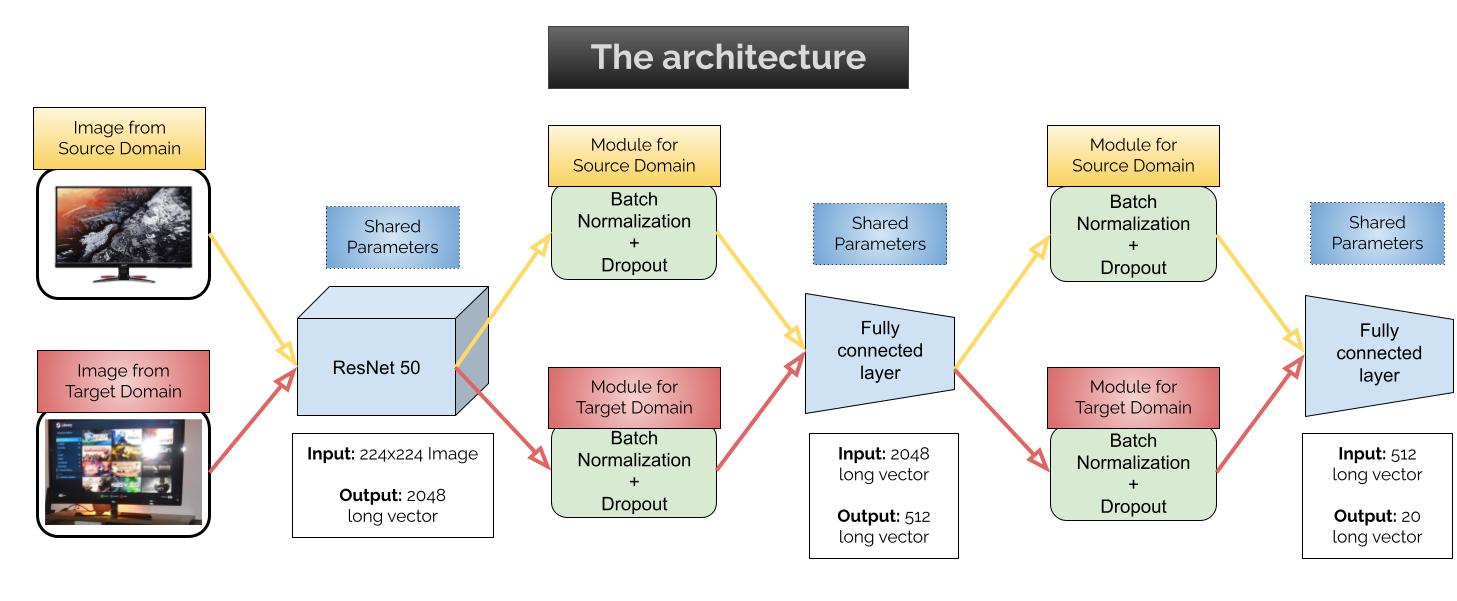

Afterwards, using the two outputs of the model we compute two losses:
*   a Cross Entropy Loss for the source output
*   a simple Entropy Loss for the traget output

and finally, thanks to backpropagation, the weights of the model are updated at each epoch.

---

# Preprocessing

❗⚠⚠⚠⚠⚠⚠❗

First of all, in order to be sure that all the code works fine you need to have [this](https://drive.google.com/drive/folders/1B2kykBxzX-D8BTc3hkZMJRhA9ROYM0hY?usp=sharing) folder in your Google Drive main folder.

In this first section we import the necessary libraries and extract our data. \\
We rely on the `torchvision.datasets.ImageFolder` utility for the data loading.

## Loading the libraries and downloading the data

In [ ]:
# Importing libraries 
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
import glob
from PIL import Image
from google.colab import drive
import os
import pandas as pd
import sklearn.model_selection
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [ ]:
# Mounting the personal Google Drive directory
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The only requirement for extracting the data is to have the folder containg the dataset on the main drive folder.

In [ ]:
# Unzipping the Adaptiope.zip file present in my Drive folder
!unzip "/content/gdrive/MyDrive/Deep Learning project 2022/Adaptiope.zip" -d "/content/dataset" &> /dev/null

We'd like to create another folder that only contains the required objects. \\
These objects are from the 20 categories selected in the project.

In [ ]:
# The list of required objects
required_objects = ['backpack', 'bookcase', 'car jack', 'comb', 'crown', 
                    'file cabinet', 'flat iron', 'game controller', 'glasses', 
                    'helicopter', 'ice skates', 'letter tray', 'monitor', 'mug',
                    'network switch', 'over-ear headphones', 'pen', 'purse',
                    'stand mixer', 'stroller']

In [ ]:
# Now we can remove the undesired folders:
!rm -rf 'dataset/Adaptiope/synthetic'
for folder in glob.glob('dataset/Adaptiope/product_images/*'):
  name = folder[33:]
  if name not in required_objects:
    !rm -rf "$folder"

for folder in glob.glob('dataset/Adaptiope/real_life/*'):
  name = folder[28:]
  if name not in required_objects:
    !rm -rf "$folder"

## Creation of the `get_train_data` function

We create our data loaders. \\
Please read the comments in the following block in order to have a more precise idea of our reasoning.

In [ ]:
'''
Function that creates the dataloaders for the training set and the validation set.
It requires:
- the path of the directory that contains the folders of the images we are interested in
- the batch size of the training data loader
- the batch size of the validation data loader. The default is 256
- the size of the training ids set. The default is 80%
- the seed for the split. The default is 42

It returns:
- the training data loader
- the validation data loader
'''

def get_train_data(path, train_batch_size, val_batch_size=256, train_size=0.8, seed=42): 

  '''
  We define the tranformations that will be applied to the images.
  At first, we
  - tranform it to a tensor
  - we resize it to 224x224, in order to be fed to the ResNet50 network in the 
    first phase of our model
  '''
  transform = list()    
  transform.append(T.ToTensor()) 
  transform.append(T.Resize((224, 224)))  

  '''
  Then we apply data augmentation. 
  Doing this after the crop reduces significantly our execution time without
  any modification to our experimental results.
  In particular, the data augmentation will be composed of: 
  - Color Jittering with brigthness=0.5, contrast=0.5 and saturation=0.5
  - Gaussian Blur with kernel size (7,7) and sigma from 0.1 to 3
  - An affine tranformation, that adds slight rotation, translation and rescaling
  - A random flip of the image with probability 0.5
  and we apply the data augmentation with probability 0.65
  '''
  random_transform = list()
  random_transform.append(T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5))
  random_transform.append(T.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 3)))
  random_transform.append(T.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.9,1.1)))
  random_transform.append(T.RandomHorizontalFlip(p=0.5))                    
  transform.append(T.RandomApply(random_transform,0.65))

  '''
  Finally we normalize the tensor using the ImageNet parameters
  '''
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))      
  transform = T.Compose(transform)


  # After having defined the transformations, let's create the Dataset
  training_data = torchvision.datasets.ImageFolder(root=path, transform=transform)


  # Let's split the data in train and validation sets following the project split:
  n_samples = len(training_data)
  train_samples = int(n_samples*train_size  + 1)

  training_data, validation_data = torch.utils.data.random_split(training_data, 
      [train_samples, n_samples-train_samples], generator=torch.Generator().manual_seed(seed))

  # Finally, let's create the train and validation dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, train_batch_size, shuffle=True, drop_last=True)
  val_loader = torch.utils.data.DataLoader(validation_data, val_batch_size, shuffle=False, drop_last=False)
  
  return train_loader, val_loader

# Main Functions

## Creation of the model

At this point we implement our net. \\
It uses a **pretrained ResNet50** at its beggining where we freeze the first 2 blocks and the first 4 components of the 3-rd block. \\
The idea behind using ResNet comes from a deep research in the literature regarding UDA. In particular we refer to this [article](https://arxiv.org/abs/2106.09388). \\
As one can see from the results using resnet is an effective choice. \\
We also highlight that the successive parts of our net **differ** from the one in the article. \\
In particular we decide to adopt a procedure for domain aligment following an approach closer to the one faced during the laboratory part of the course. \\
We recall the scheme already presented: \\

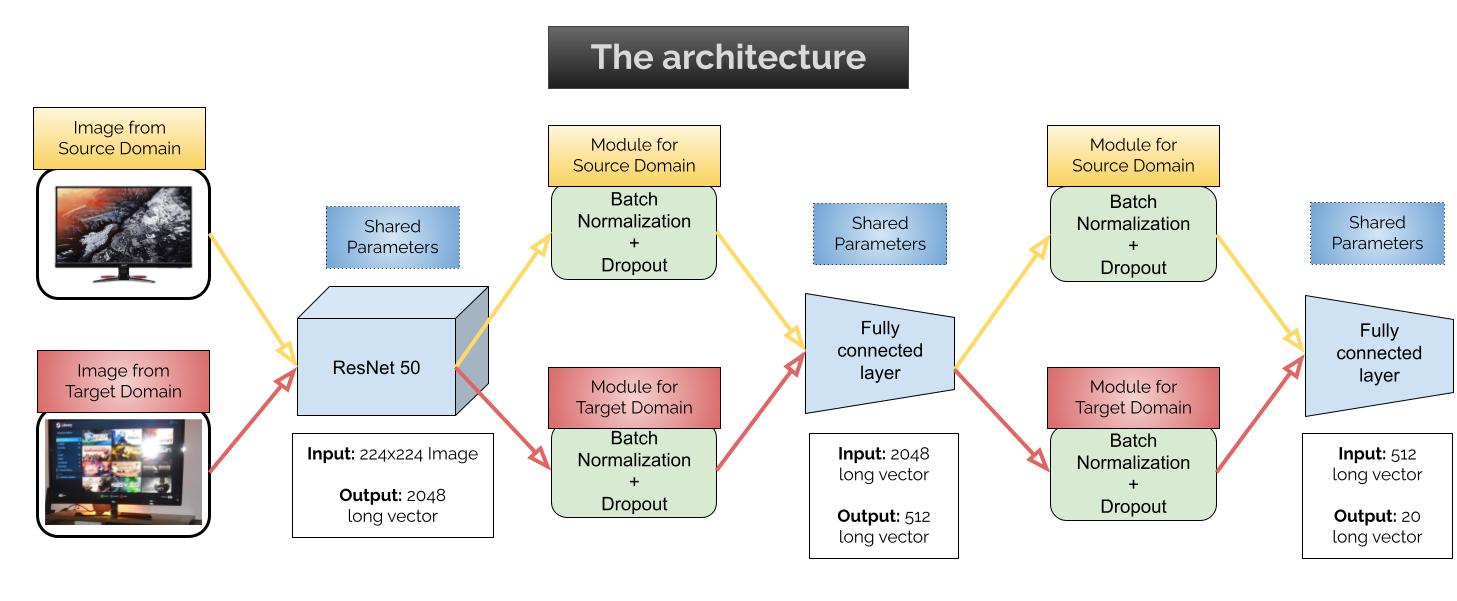


The output is composed by 20 features. \\
An interesting point of our implementation is how we manage both the fact of having only one input (Supervised Only case) and having two inputs (our UDA case). 

In [ ]:
'''
Creation of the DomainAdaptationNet class
It will inherit from the nn.Module class
'''

class DomainAdaptationNet(torch.nn.Module):

  def __init__(self):

    super(DomainAdaptationNet, self).__init__()
    
    '''
    The model is based upon the pretrained ResNet50 model
    We freeze the first 2 blocks and the first 4 components of the 3-rd block
    The last fully connected layer will have 2048 output features
    '''
    self.out_features_fc = 2048
    self.model = torchvision.models.resnet50(pretrained=True)
    for param in self.model.parameters():
      param.requires_grad = False  
    for param in self.model.layer2[4:].parameters():
        param.requires_grad = True
    for param in self.model.layer3.parameters():
        param.requires_grad = True
    for param in self.model.layer4.parameters():
        param.requires_grad = True
    self.model.fc = torch.nn.Linear(in_features=2048, out_features=self.out_features_fc, bias=True)
    for param in self.model.fc.parameters():
        param.requires_grad = True

    '''
    Atfer the ResNet module, we apply one Batch Normalization layer.
    In particular, we will have a layer for the source domain and one for the target domain.
    After the BN modules, we apply a Dropout layer with probablity 0.5
    Then we will feed the result to another Linear layer and another pair of source&target BN+DO layers.
    Finally, we feed the result to a linear layer to classify the 20 object classes.
    '''

    self.BNs1 = torch.nn.BatchNorm1d(self.out_features_fc)
    self.DOs1 = torch.nn.Dropout(p=0.5)
    self.BNt1 = torch.nn.BatchNorm1d(self.out_features_fc)
    self.DOt1 = torch.nn.Dropout(p=0.5)

    self.fc1 = torch.nn.Linear(in_features=self.out_features_fc, out_features=512, bias=True)

    self.BNs2 = torch.nn.BatchNorm1d(512)
    self.DOs2 = torch.nn.Dropout(p=0.5)
    self.BNt2 = torch.nn.BatchNorm1d(512)
    self.DOt2 = torch.nn.Dropout(p=0.5)

    self.classifier = torch.nn.Linear(in_features=512, out_features=20, bias=True)

  
  '''
  Here we define the forward function.
  The main purpose is to use it to perform Domain Alignment.
  Nonetheless, we can use this function also if we would like to test only on a specific dataset or
  if we would like to perform supervised classification only on the source domain.
  In case of a Domain Adaptation task, it will take as input two tensors:
  - x that corresponds to the source images batch
  - y that corresponds to the target images batch
  
  In case of testing for a specific dataset, we input
  - (x, None) if we want to test on the source images batch x
  - (None, y) if we want to test on the target images batch y

  In case of supervised classification on the source domain, we input
  - x that corresponds to the source images batch
  - y = None
  '''

  def forward(self, x, y):

    ''' 
    For each image batch, we use the model defined above
    After each BN + DO layer, we also apply the ReLu function
    '''

    if x is not None: # If we have a source-domain image batch

      x = self.model(x)
      x = self.BNs1(x)
      x = self.DOs1(x)
      x = F.relu(x)
      x = self.fc1(x)
      x = self.BNs2(x)
      x = self.DOs2(x)
      x = F.relu(x)   
      x = self.classifier(x)

    if y is not None: # If we have a target-domain image batch

      y = self.model(y)
      y = self.BNt1(y)
      y = self.DOt1(y)
      y = F.relu(y)
      y = self.fc1(y)
      y = self.BNt2(y)
      y = self.DOt2(y)
      y = F.relu(y)   
      y = self.classifier(y)

    return x,y

## Loss functions

In these following subsections we introduce the loss functions used. \\
We are using the ones that we have seen during our course. \\

### Define cross-entropy loss function

For the labeled source data we compute the cross entropy loss

$L^{s}(\theta) = - \frac{1}{m} \displaystyle \sum^{m}_{i=1} y_{i}\log{p_i}$

where $p_i$ is the output from the network for the $i^{th}$ input and $y_i$ is the corresponding ground truth.

In [ ]:
'''
Function that computes the Cross Entropy loss
It requires:
- the outputs tensor
- the targets tensor

It outputs the loss
'''

def ce_loss_function(outputs, targets):
  loss = torch.nn.CrossEntropyLoss()(outputs, targets)
  return loss

### Define Entropy loss function

For the unlabeled target samples we can no longer compute the cross entropy loss because the labels are not available. Instead we will compute the Entropy loss, which is defined as follows:

$L^{t}(\theta) = - \frac{1}{m} \displaystyle \sum^{m}_{i=1} p_{i}\log{p_i}$

where $p_i$ is the output from the network for the $i^{th}$ input.

In [ ]:
'''
Function that computes the Entropy loss
It requires:
- the outputs tensor x

It outputs the loss
'''

def entropy_loss_function(x):
  p = F.softmax(x, dim=1)
  q = F.log_softmax(x, dim=1)
  b = p * q
  b = -1.0 * b.sum(-1).mean()
  return b

## Optimizer

We present our optimizer function.   
In particular during our tests we have used two optimizers, *SGD* and *ADAM*.  
In practice, since we saw better results using *SGD*, almost all tests case are done using this optimizer. \\
We also want to highlight the fact that we tried to enable the **Nesterov** utility for *SGD* and tuning the associated parameter but the results where not increased, so we disabled it.

In [ ]:
'''
Function that defines the optimizer function
It requires:
- the model on which we apply the optimizer
- the type of optimizer to use.
  In particular we use 'adam' if we want to use Adam and 'sgd' if we want to use Stochastic Gradient Descent
- the optimizer-specific keyworded arguments
'''

def get_optimizer(net, opt_type, lr=0.01, **kwargs):

  if opt_type=='adam':
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, **kwargs)

  if opt_type=='sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr = lr, **kwargs)
  
  return optimizer

## Train and test functions

The following is the function used to train each epoch.   
It can be used for both supervised (on one domain) and unsupervised (on two domains) learning.

In [ ]:
'''
Function to be used during each training epoch
It requires:
- the model
- the source training data loader
- the target training data loader. In case of supervised classification only on 
  the source domain, we put this value to None
- the optimizer
- the cross entropy loss function
- the entropy loss function
- the entropy loss weight, i.e. the importance given to the entropy loss wrt the ce loss
- the device

In case of supervised classification only on the source domain, it returns:
- the cross entropy loss
- the accuracy on the training source set

In case of semi-supervised domain alignment, it returns:
- the cross entropy loss
- the entropy loss
- the accuracy on the training source set
'''

def train(net, source_data_loader, target_data_loader, optimizer, ce_loss_f,
          entropy_loss_f, entropy_loss_weight, device='cuda:0'):
  
  # We instantiate the variables used to assess the quality of the model
  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_en_loss = 0.
  cumulative_accuracy = 0.
  
  # In case of DA, we create an iterator for the target dataset
  if target_data_loader is not None: target_iter = iter(target_data_loader)

  # We set the model into training mode (having BN)
  net.train()
  for batch_idx, (inputs_source, targets) in enumerate(source_data_loader):
    
    # Load data into GPU
    inputs_source = inputs_source.to(device)
    targets = targets.to(device)

    # In case of supervised learning, this variable will be None, otherwise it will
    # be updated in the next if
    inputs_target = None

    # In case of DA...
    if target_data_loader is not None:
      # ...we get target data. If the target iterator reaches the end, restart the process
      # Note: we forget about the labels of the target set
      try:
        inputs_target, _ = next(target_iter)
      except:
        target_iter = iter(target_data_loader)
        inputs_target, _ = next(target_iter)

      # Load also the target data into the GPU
      inputs_target = inputs_target.to(device)
      
    # Forward pass
    source_output, target_output = net(inputs_source, inputs_target)
    
    # Apply the Cross Entropy loss and define the complete loss value
    ce_loss = ce_loss_f(source_output,targets)
    loss = ce_loss

    # In case of DA...
    if target_data_loader is not None:
      # ...apply the Entropy loss and add it to the loss value (multiplied by a hyperparameter)
      en_loss = entropy_loss_f(target_output)
      loss += entropy_loss_weight * en_loss
    
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Reset the optimizer
    optimizer.zero_grad()

    # We retrieve the output parameters
    source_samples+=inputs_source.shape[0]
    cumulative_ce_loss += ce_loss.item()
    
    _, predicted = source_output.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

    if target_data_loader is not None: 
      target_samples+=inputs_target.shape[0]
      cumulative_en_loss += en_loss.item()
    else: 
      target_samples = 1

  return cumulative_ce_loss/source_samples, cumulative_en_loss/target_samples, cumulative_accuracy/source_samples*100

The following is the function used to test each epoch.   
We usually use it for both the source and test datasets. The domain on which the image is tested needs to be specified by the use of a string in the input, since different domains will use different Batch Normalization layers.

In the outputs, we also include the confusion matrix.

In [ ]:
'''
Function to be used for testing the model
It requires:
- the model
- the validation set data loader
- the cross entropy loss function
- the validation set domain type in form of a string.
  If it's 'source' we will pass it as a source image
  If it's 'target' we will pass it as a target image (the BN parameters change)
- the device

It returns:
- the cross entropy loss
- the accuracy on the validation set
- the confusion matrix
'''

def test(net, data_loader, cost_function, val_type, device='cuda:0'):

  # We instantiate the variables used to assess the quality of the model
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.
  confusion_mat = torch.zeros([20, 20], dtype=torch.int32)

  # We set the model into testing mode (having BN)
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      if val_type == 'source': # If we want to evaluate the model on the source domain pass (batch, None)
        outputs, _ = net(inputs, None)
      elif val_type == 'target': # If we want to evaluate the model on the target domain pass (None, batch)
        _, outputs = net(None, inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Retrieve the output parameters
      samples += inputs.shape[0]
      cumulative_loss += loss.item() 
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

      for j in range(20):
        for i in range(20):
          confusion_mat[i][j] = confusion_mat[i][j] + predicted[targets.eq(j)].eq(i).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100, confusion_mat

## Main function

This is the main function, used for training the model (can be supervised or UDA) and prints the results for each epoch. The model can be saved in Google Drive automatically by enabling the parameter at the beginning.

This function returns the metrics of the model for future plotting.

In [ ]:
'''
Function that runs the model and perfomrs evaluations on the performance
It requires:
- a boolean. It's true if we want to use domain adaptation, false is we just
  want to perform supervised learning on the source domain
- the path of the source images
- the path of the target images
- the name of the model, to save the model and the metrics on Tensorboard
- the number of epochs
- the size of the batch of the training set. Default: 64
- the size of the batch of the validation set. Default: 256
- the train_set/entire_set fraction for the training-validation set split
- the hyperparameter that determines the weight of the entropy loss wrt to the cross entropy loss
- the device
- a boolean. It's true if we want to test also on the target set, false otherwise
- the type of optimizer, either 'sgd' or 'adam'
- the optimizer-specific keyworded arguments

It returns:
- the vector that contains the accuracy on the source validation set
- the vector that contains the accuracy on the target validation set.
  If test_on_target=False it will return an empty set
- the vector that contains the losses on the source validation set
- the vector that contains the losses on the target validation set.
  If test_on_target=False it will return an empty set 
- the vector that contains the confusion matrices (a tensor) on the source validation set
- the vector that contains the confusion matrices (a tensor) on the target validation set.
  If test_on_target=False it will return an empty set 
'''

def main_for_train(domain_adaptation,
        source_path,
        target_path,
        name,
        epochs=10,
        train_batch_size=64, 
        val_batch_size=256,
        train_size=0.8,
        entropy_loss_weight=0.1,
        device='cuda:0', 
        test_on_target = True,
        opt_type='sgd',
        lr=0.01,
        **kwargs):
  
  # Parameters that if enabled, respectively save the metrics on TensorBoard and the model on Drive
  tb = False
  save = False
  
  # Define the Tensorboard writer  
  if tb: writer = SummaryWriter(log_dir="/content/gdrive/MyDrive/Deep Learning project 2022/outputs/runs/ResNetDA/"+name)
  
  # Define the DomainAdaptation Net
  net = DomainAdaptationNet().to(device)

  # Define the optimizer
  optimizer = get_optimizer(net, opt_type, lr=lr, **kwargs)

  # Create the 4 data loaders
  source_train_loader, source_val_loader = get_train_data(source_path, train_batch_size, val_batch_size, train_size=train_size)
  target_train_loader, target_val_loader = get_train_data(target_path, train_batch_size, val_batch_size, train_size=train_size)

  # Create the accuracy and loss vectors
  v_source_accuracy = []
  v_source_loss = []
  v_source_confusion_matrix = []
  v_target_accuracy = []
  v_target_loss = []
  v_target_confusion_matrix = []


  # Start the training epochs
  for e in range(epochs):

    # Change the learning rate after the 8th epoch
    if e==8: optimizer = get_optimizer(net, opt_type, lr=lr/10, **kwargs)

    print('Epoch: {:d}'.format(e+1))
    t = time()

    
    ## TRAINING
    if domain_adaptation: # If training with DA

      train_ce_loss, train_en_loss, train_accuracy = train(net, source_train_loader, target_train_loader, 
            optimizer, ce_loss_function, entropy_loss_function, entropy_loss_weight, device)
      if tb:
        writer.add_scalar("Train/EntropyLoss", train_en_loss, e+1)
      print('\t Train: Cross entropy loss {:.5f}, Accuracy {:.2f}, Entropy loss {:.5f}'.format(train_ce_loss, train_accuracy, train_en_loss))
    
    else: # In case of supervised learning, we need to specify None as training_target_loader

      train_ce_loss, _, train_accuracy = train(net, source_train_loader, None, optimizer, ce_loss_function,
            entropy_loss_function, entropy_loss_weight, device)
      print('\t Train: Cross entropy loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_accuracy))

    if tb:
      writer.add_scalar("Train/CELoss", train_ce_loss, e+1)
      writer.add_scalar("Train/Accuracy", train_accuracy, e+1)
    print('\t The training lasted '+str((time()-t)/60)+' minutes')


    ## TESTING ON SOURCE DATASET
    t1 = time()
    source_val_loss, source_val_accuracy, source_confusion_matrix = test(net, source_val_loader, ce_loss_function, 'source', device)
    print('\t Test: Source loss {:.5f}, Source accuracy {:.2f}'.format(source_val_loss, source_val_accuracy))
    print('\t The first test lasted '+str((time()-t1)/60)+' minutes')
    if tb:
      writer.add_scalar("SourceValidation/Loss", source_val_loss, e+1)
      writer.add_scalar("SourceValidation/Accuracy", source_val_accuracy, e+1)
    v_source_accuracy.append(source_val_accuracy)
    v_source_loss.append(source_val_loss)
    v_source_confusion_matrix.append(source_confusion_matrix)


    ## TESTING ON TARGET DATASET
    if test_on_target:
      t1 = time()

      if domain_adaptation: # If training with DA, we evaluate the target dataset with the target BN parameters
        target_val_loss, target_val_accuracy, target_confusion_matrix = test(net, target_val_loader, ce_loss_function, 'target', device)
      else: # If we do Supervised learning, we evaluate the target dataset using the BN parameters of the source set
            # because the BN parameters of the target set aren't defined (or better, are more or less random)
        target_val_loss, target_val_accuracy, target_confusion_matrix = test(net, target_val_loader, ce_loss_function, 'source', device)

      print('\t Test: Target loss {:.5f}, Target accuracy {:.2f}'.format(target_val_loss, target_val_accuracy))
      print('\t The second test lasted '+str((time()-t1)/60)+' minutes')
      if tb:
        writer.add_scalar("TargetValidation/Loss", target_val_loss, e+1)
        writer.add_scalar("TargetValidation/Accuracy", target_val_accuracy, e+1)
      v_target_accuracy.append(target_val_accuracy)
      v_target_loss.append(target_val_loss)
      v_target_confusion_matrix.append(target_confusion_matrix)

    print('The epoch lasted '+str((time()-t)/60)+' minutes')
    print('-----------------------------------------------------')
    

  # We close the Tensorboard writer
  if tb: writer.close()

  # We save the model on Google Drive
  if save:
    try:
      torch.save({
        'epoch': epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, "/content/gdrive/MyDrive/Deep Learning project 2022/outputs/models/ResNetDA/"+name+".pth")
    except:
      print("Didn't manage to save the model")

  return v_source_accuracy, v_target_accuracy, v_source_loss, v_target_loss, v_source_confusion_matrix, v_target_confusion_matrix


# Results

***All the results that are reported here can be reproduced independently with the code in the appendix.***
The only requirement is to have run all the code above and to have our Drive folder into the main Drive directory.

At this point we insert the numerical results of our training. \\
In the **Appendix** you will be able to find all the code we have executed in order to find the proposed results. \\
Furthermore the numerical results of our simulations can be found in this file [Results.csv](https://drive.google.com/file/d/1-DmMr4wGJYK7voEe2bz_vQs8hffNlMVo/view?usp=sharing).


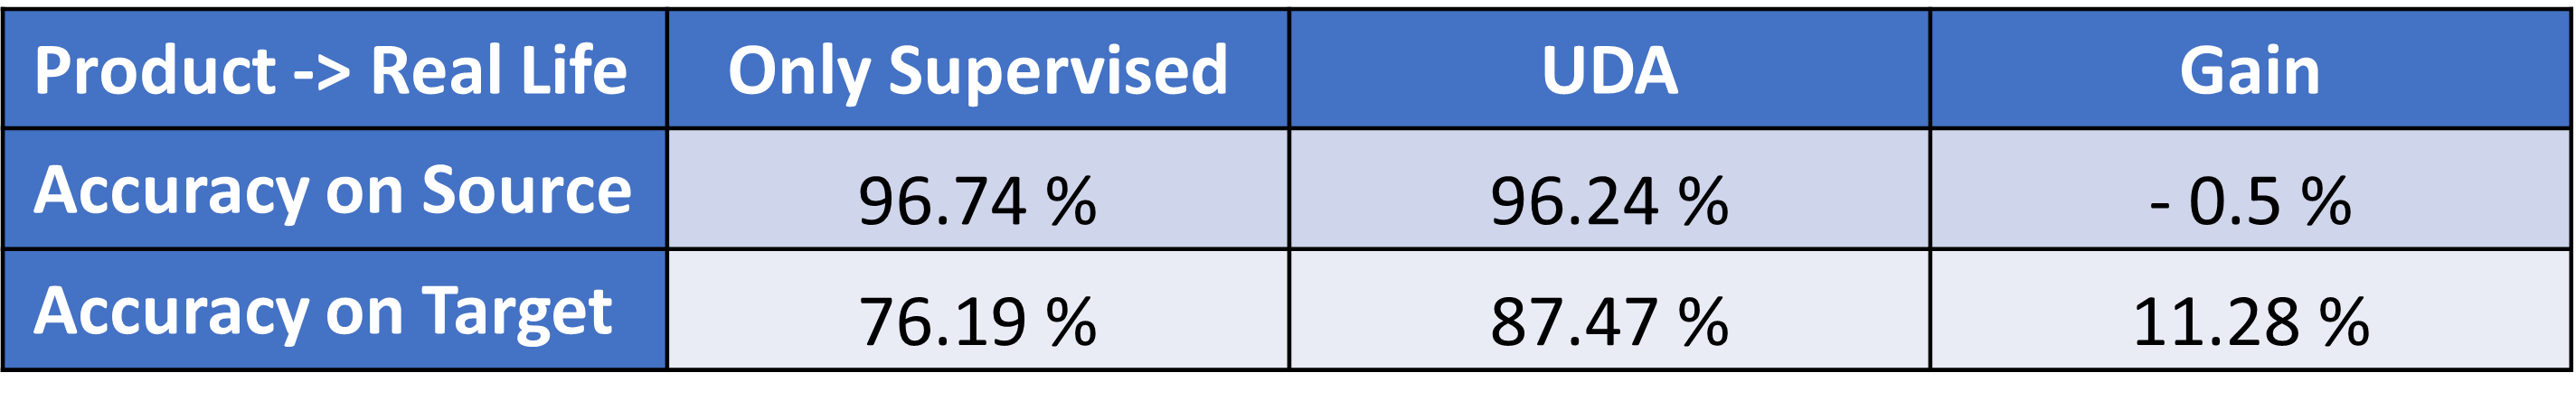

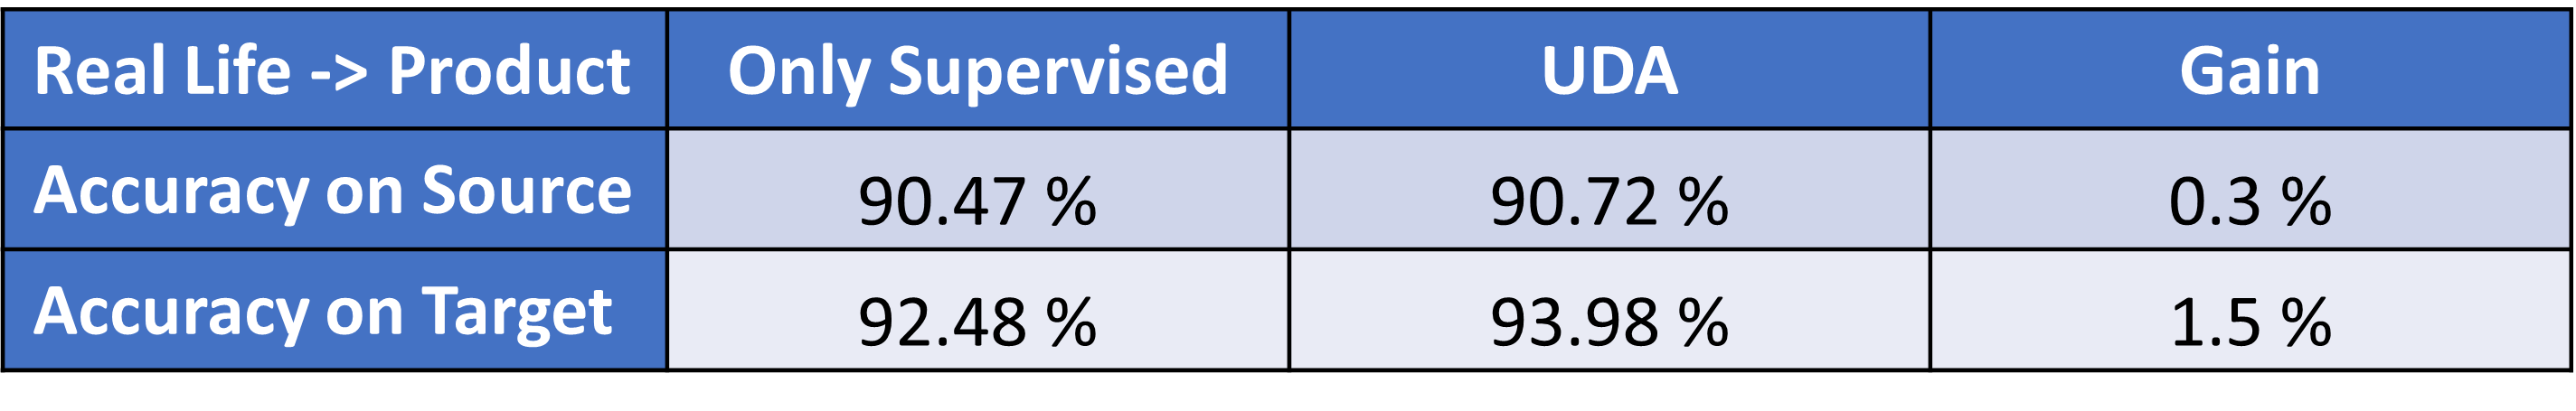

It appears clear the dicrepancy between the effectiveness of the *UDA* procedure for the two directions of our tests. We have that it is very efficient when we test on the *Real life* set achieving such large gain as our *11.28 %*. In the other direction our gain is not so satisfying but it also true that the accuracy obtained is also very high. This discrepancy may depend on the difficulty for a *product type* image (unlabelled part) to add some information to a *real life source training set*. 

The learning curves are:

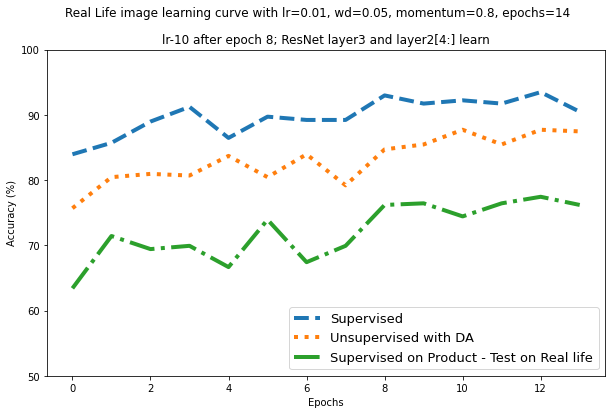

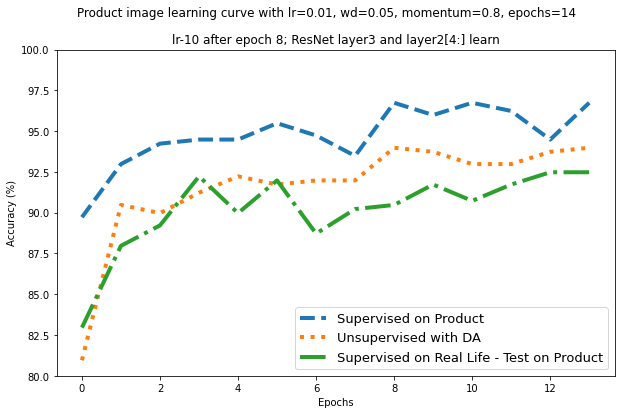

# Tuning Hyperparameters

We spent a lot of time in tuning our hyperparamters. \\
In particular we have run several experiments with different configurations of *type of optimizer*, *learning rate*, *momentum*, *weight decay*, *probability of dropout*, *entropy loss weigth decay*, *batch size* and *probability of apply the augmentation*. \\
In order to have a graphical representation of our tuning procedure we attach here the following plot that shows the difference obtained during the supervised learning on the real life domain.

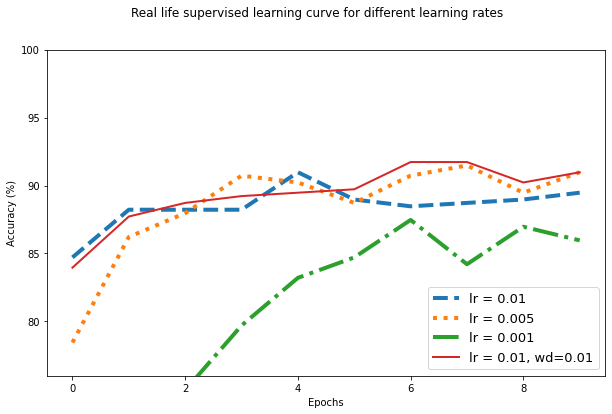

This representation highlights how much the learning rate influences our results. \\
Furthermore, for what concerns the *learning rate*, in the last experiments, and also in the ones used in the results part, we adopt a *correction* dividing it by *10* once we pass the epoch *8*. This increases the performance of the net. \\
A similar procedure has been followed for the other parameters.

# Analysis of the results of a general run with the best parameters

Here we perform a more detailed analysis of one run using the best case hyperparameters. Note that the following case is different from the case presented in the results section because when we performed that run we didn't implement all the framework to plot the following graphs.

## Analysis of the accuracies

Let's look at the accuracy curve on the Product dataset

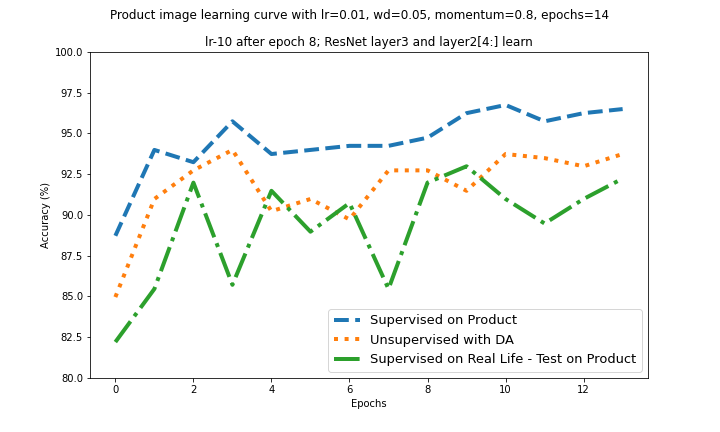

We can see from the curves that the Supervised classification reaches an accuracy of more or less 96% on the source domain.   
We can also observe that the Unsupervised curve, without Domain Alignment (Supervised classification on Real Life - Test on Product) is performing really well on this dataset even though the batch normalization layer that is used is the same as the one in the source domain. We can also notice that in this case the accuracy has a very high oscillating behaviour.
Nonetheless, the Domain Alignment strategy allows the model to learn the classification task generally better. In fact we have that the gain in the last epoch obtained thanks to the DA procedure is of $1.5\%$.

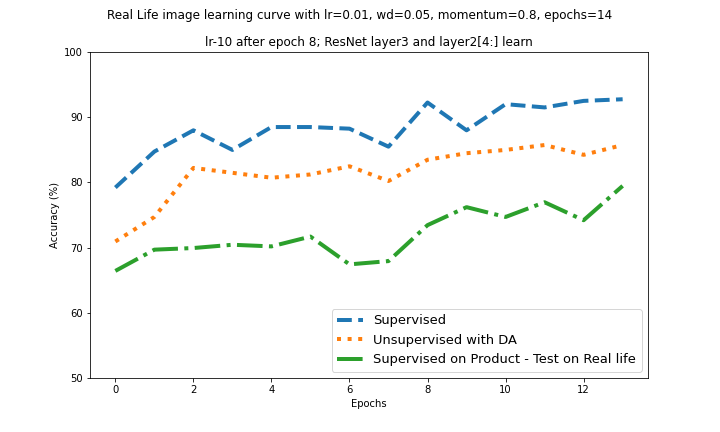

If instead we look at the accuracies obtained in the Real Life dataset, we can see that the values are significantly smaller.  
This is probably due to the fact that the real life images contain much more noise and other objects, while the product images are much more clean and usually only contain the object we want to classify.  
Furthermore, we can see that the unsupervised classification without domain alignment is performing much worse than in the product domain. Also this can be due to the fact that when the supervised model is training on product images, which are very clean, it's difficult to catch the main features of the objects. On the other hand, when training on the real life dataset, the model is able to learn the features in a much more difficult environment, and needs to focus on more details in order to separate correctly the object from the background. This will permit to have better results when using this model on the easier product dataset.  
Finally, when we use the domain alignment strategy we are able to reach an accuracy of $85.7\%$, with a gain of $6.27\%$.

## Analysis of the loss

Let's now analyze the plots of the loss, and in particular of the Cross Entropy loss

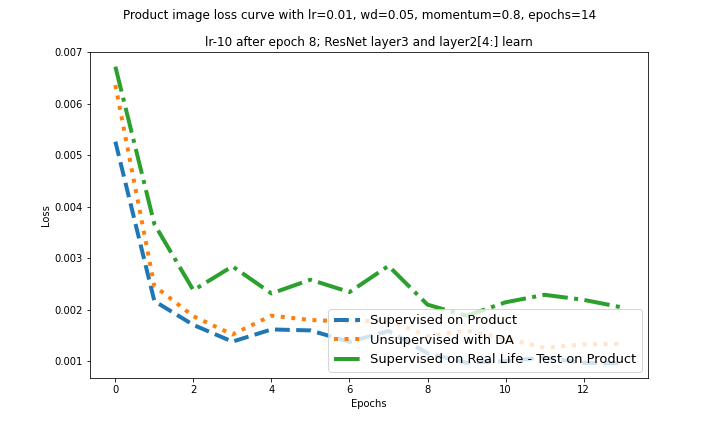

We can see that the behaviour of the 3 losses reflects the behaviour of the 3 accuracies that we presented above. In particular the green line, like we saw above, is the most oscillating one.

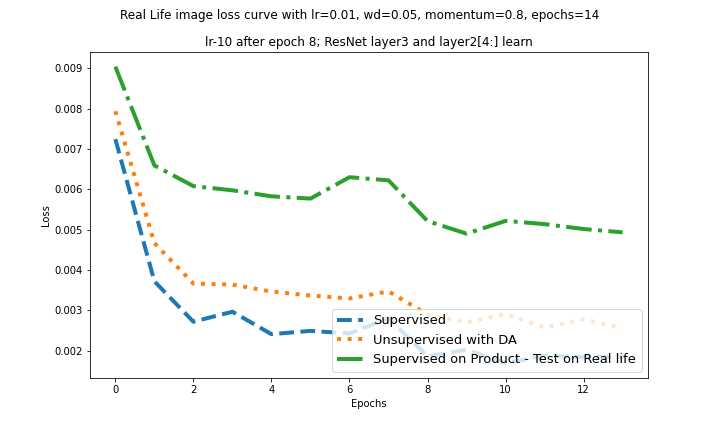

Also here we can observe the same behaviour as in the accuracies above. 

We can also observe that the losses we get when testing on the real life dataset are much higher than the ones obtained in product.

## Objects accuracies

Let's now analyze the accuracies of the different objects that are obtained in the last epoch of the UDA models.

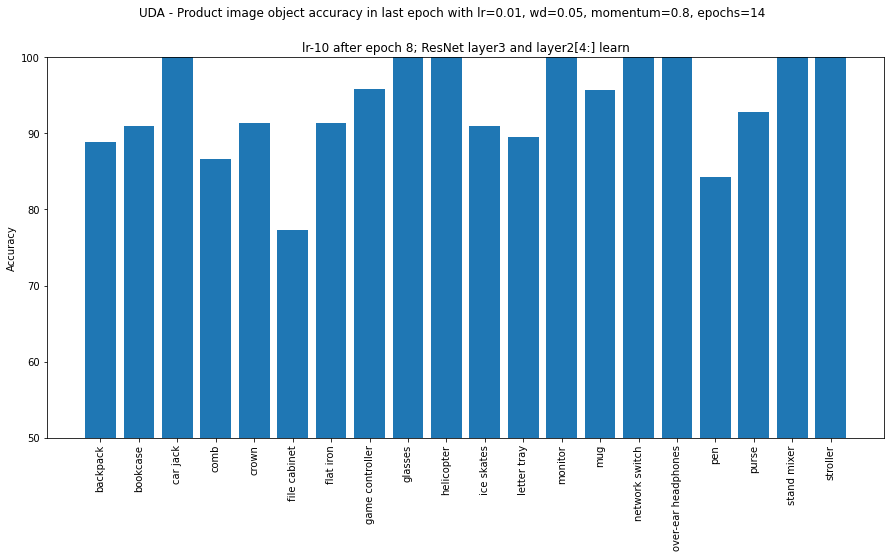

We can see that the accuracies of the product images are all generally very high.  
In particular we have that the *file cabinet* is the object with the lowest accuracy. This could be given by the fact that this object doesn't have strong characteristics and often the product images are showing white file cabinets on a white background.  
We can also see that there are many objects that reach an accuracy of $100\%$

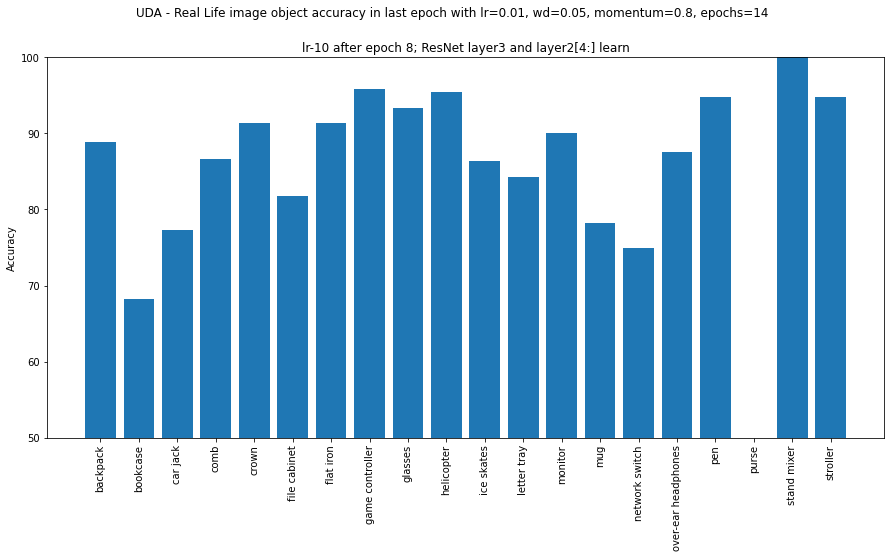

In the case of the real life images, the accuracies of the objects are lower and also significantly more heterogeneous.  
We can see that the purse is performing really badly, even worse than $50\%$ accuracy. This could happen because in the product images the purse almost everytime are showed with a clear bag strap, while instead in the real life images it's not always the case.

Is the bad performance of the purse and the bookcase happening only in the last epoch or is it performing badly since the beginning of the training? Let's check

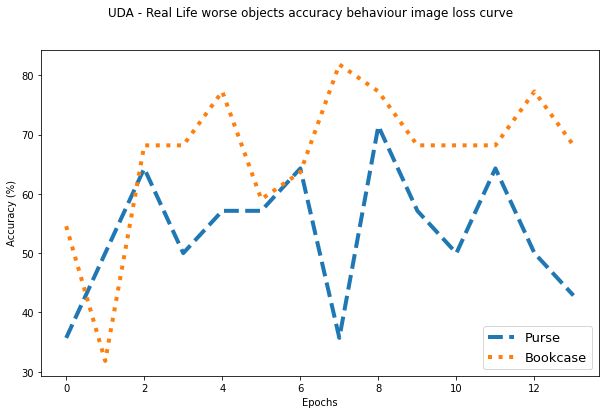

In the last epoch the accuracies are particularly bad, even though the model is never able to recognize a purse with an accuracy of more than $\sim 70\%$, while the bookcase reaches an accuracy of $\sim 81\%$ in the 8th epoch.

# Conclusion

In this project we have implemented an Unsupervised Domain Alignment technique and we have seen how much it influences the performance on the target domain.

We have presented our best case obtained in our simulations and also the procedure that has led us to the choice of our hyperparameters. 

Morevore we presented a detailed analysis of a particular training run with our parameters. 

A further study of the best parameters or the best architecture could be performed.

# Appendix

Here we propose the code to run the code yourself. 
In order to run it without any trouble, you will need the folder in the drive main directory to load the data and save the results.

In [ ]:
# Parameters used in the best case scenario

experiment_epochs=14
experiment_batch_size = 64
experiment_lr = 0.01
experiment_wd = 0.05
experiment_momentum = 0.8
experiment_elw = 0.1
comments = "lr-10 after epoch 8; ResNet learning after layer2[4:]"

The following sections can be used to train the model in a particular domain

### Supervised learning only on Real Life images

In [ ]:
rl_supervised_source, rl_supervised_target, rl_source_cm, rl_target_cm = main_for_train(
    False,
    'dataset/Adaptiope/real_life/',
    'dataset/Adaptiope/product_images/',
    "SupervisedRealLife_01",
    epochs=experiment_epochs,
    train_batch_size=64, 
    train_size=0.8,
    entropy_loss_weight=0.1,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

### Supervised learning on Real Life + Unsupervised learning on Product

In [ ]:
rl_unsupervised_source, rl_unsupervised_target, _, _ = main_for_train(
    True,
    'dataset/Adaptiope/real_life/',
    'dataset/Adaptiope/product_images/',
    "UnsupervisedProduct_01",
    epochs = 10,
    train_batch_size=64, 
    train_size=0.8,
    entropy_loss_weight = 0.3,
    device='cuda:0', 
    opt_type='sgd',
    lr = 0.005, 
    weight_decay = 0.01, 
    momentum = 0.8)

"""
- lr=0.01, wd=0.001, momentum = 0.8, entr_lw=0.3, batch=64, epochs=7: 
  Best target acc = 93.48% (Ep. 5);   Final acc = 92.98%

- lr=0.005, wd=0.01, momentum = 0.8, entr_lw=0.3, batch=128, epochs=10: 
  Best target acc = 93.98% (Ep. 9);   Final acc = 91.48%
"""

### Supervised learning only on Product images

In [ ]:
p_supervised_source, p_supervised_target = main_for_train(
    False,
    'dataset/Adaptiope/product_images/',
    'dataset/Adaptiope/real_life/',
    "SupervisedProduct_01",
    epochs=experiment_epochs,
    train_batch_size=64, 
    train_size=0.8,
    entropy_loss_weight=0.1,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

### Supervised learning on Product + Unsupervised learning on Real Life

In [ ]:
p_unsupervised_source, p_unsupervised_target, _, _ = main_for_train(
    True,
    'dataset/Adaptiope/product_images/',
    'dataset/Adaptiope/real_life/',
    "UnsupervisedRealLife_01",
    epochs = 10,
    train_batch_size=128, 
    train_size=0.8,
    entropy_loss_weight = 0.1,
    device='cuda:0', 
    opt_type='sgd',
    lr = 0.01, 
    weight_decay = 0.001, 
    momentum = 0.8)

""" Tests
- lr=0.01, wd=0.001, momentum = 0.8, entr_lw=0.3, batch=128, epochs=7: 
  Best target acc = 83.71% (Ep. 5);   Final acc = 81.45%

- lr=0.005, wd=0.01, momentum = 0.8, entr_lw=0.3, batch=128, epochs=10: 
  Best target acc = 82.96% (Ep. 10);   Final acc = 82.96%

- lr=0.005, wd=0.01, momentum = 0.2, entr_lw=0.3, batch=128, epochs=10: 
  Best target acc = 73.43% (Ep. 10);   Final acc = 73.43%

- lr=0.005, wd=0.01, momentum = 1, entr_lw=0.3, batch=128, epochs=10: 
  Best target acc = 78.20% (Ep. 3);   Final acc = 60.65%

- lr=0.01, wd=0.001, momentum = 0.85, entr_lw=0.1, batch=128, epochs=10: 
  Best target acc = 83.46% (Ep. 9);   Final acc = 81.45%

"""

## Plots

The following code presents the general framework we have used to plot all the results present in the drive folder `images` and in the `data.csv`

Epoch: 1
	 Train: Cross entropy loss 0.03492, Accuracy 39.94
	 The training lasted 1.5449145317077637 minutes
	 Test: Source loss 0.00724, Source accuracy 79.20
	 The first test lasted 0.3590529521306356 minutes
	 Test: Target loss 0.00672, Target accuracy 82.21
	 The second test lasted 0.2268285353978475 minutes
The epoch lasted 2.130840214093526 minutes
-----------------------------------------------------
Epoch: 2
	 Train: Cross entropy loss 0.01296, Accuracy 82.56
	 The training lasted 1.5207704663276673 minutes
	 Test: Source loss 0.00372, Source accuracy 84.71
	 The first test lasted 0.359403665860494 minutes
	 Test: Target loss 0.00366, Target accuracy 85.46
	 The second test lasted 0.2314419666926066 minutes
The epoch lasted 2.1116454720497133 minutes
-----------------------------------------------------
Epoch: 3
	 Train: Cross entropy loss 0.00769, Accuracy 90.38
	 The training lasted 1.5410067081451415 minutes
	 Test: Source loss 0.00272, Source accuracy 87.97
	 The first tes

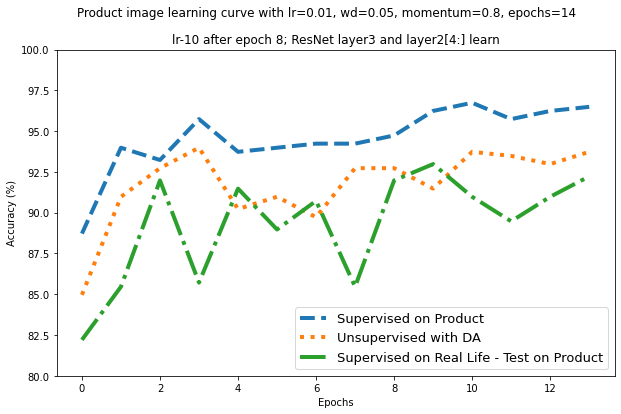

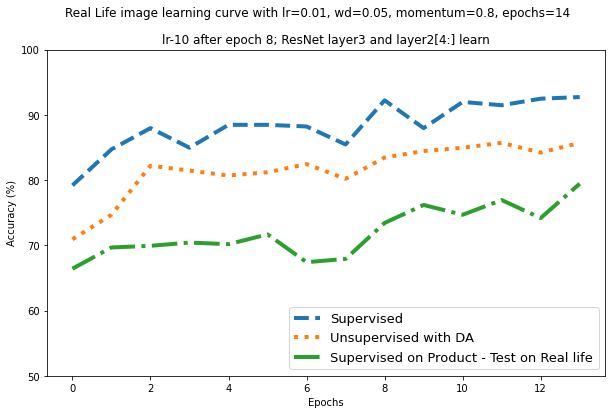

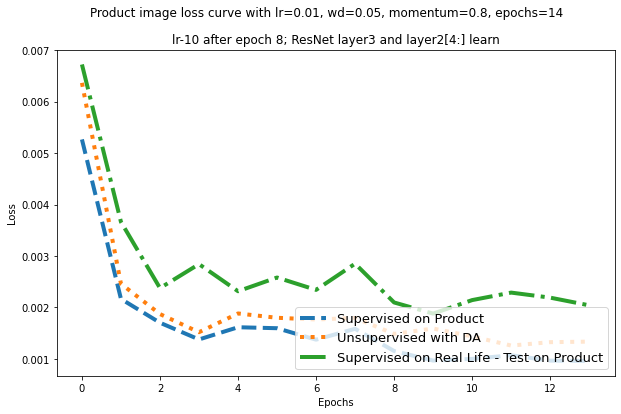

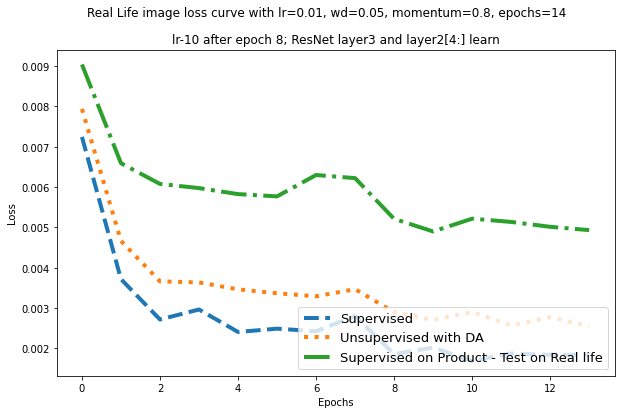

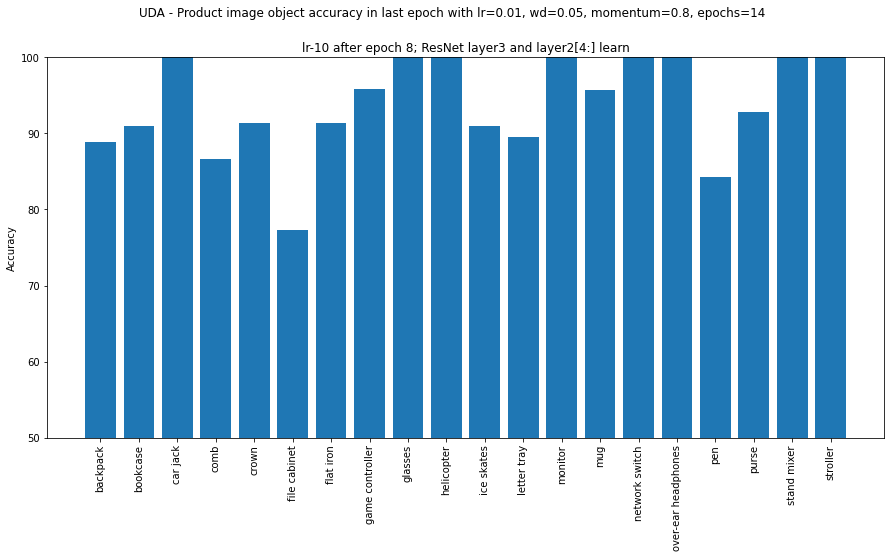

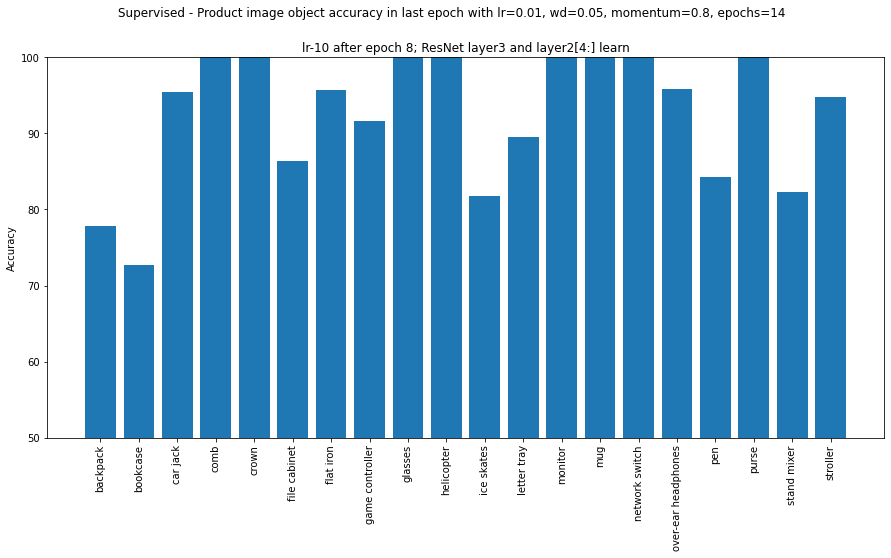

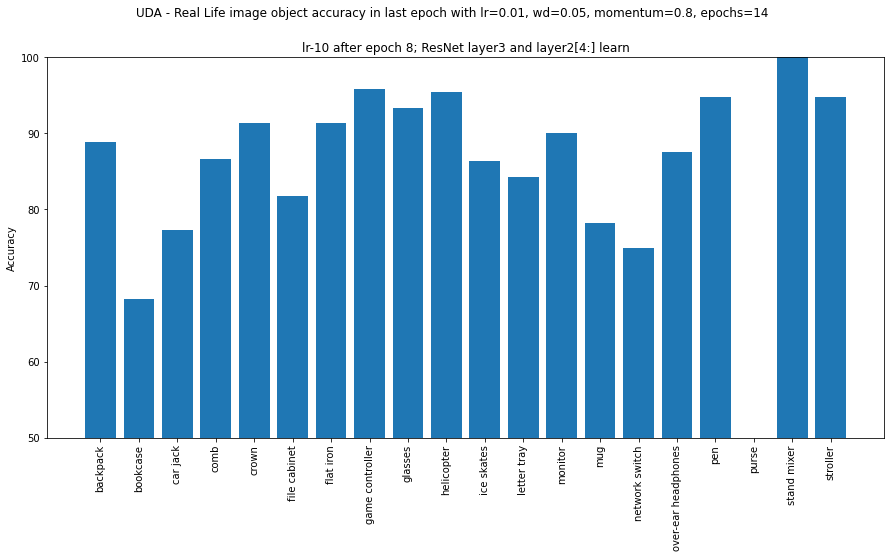

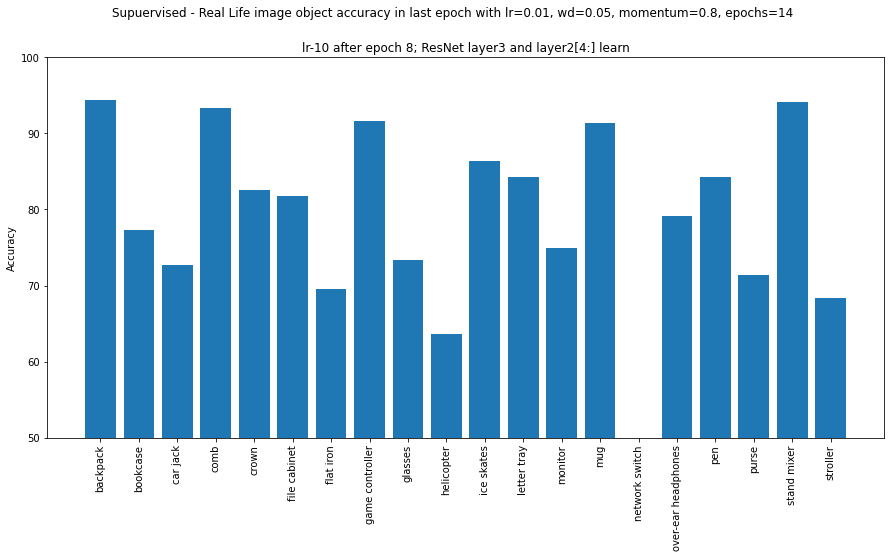

In [ ]:
experiment_epochs=14
experiment_batch_size = 64
experiment_lr = 0.01
experiment_wd = 0.05
experiment_momentum = 0.8
experiment_elw = 0.1
comments = "lr-10 after epoch 8; ResNet layer3 and layer2[4:] learn"

rl_sup_s, rl_sup_t, rl_sup_s_loss, rl_sup_t_loss, rl_sup_s_cm, rl_sup_t_cm = main_for_train(
    False,
    'dataset/Adaptiope/real_life/',
    'dataset/Adaptiope/product_images/',
    "SupervisedRealLife_02",
    epochs=experiment_epochs,
    train_batch_size=experiment_batch_size, 
    train_size=0.8,
    entropy_loss_weight=experiment_elw,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

p_sup_s, p_sup_t, p_sup_s_loss, p_sup_t_loss, p_sup_s_cm, p_sup_t_cm = main_for_train(
    False,
    'dataset/Adaptiope/product_images/',
    'dataset/Adaptiope/real_life/',
    "SupervisedProduct_02",
    epochs=experiment_epochs,
    train_batch_size=experiment_batch_size, 
    train_size=0.8,
    entropy_loss_weight=experiment_elw,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

rl_unsup_s, rl_unsup_t, rl_unsup_s_loss, rl_unsup_t_loss, rl_unsup_s_cm, rl_unsup_t_cm = main_for_train(
    True,
    'dataset/Adaptiope/real_life/',
    'dataset/Adaptiope/product_images/',
    "UnsupervisedProduct_02",
    epochs=experiment_epochs,
    train_batch_size=experiment_batch_size, 
    train_size=0.8,
    entropy_loss_weight=experiment_elw,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

p_unsup_s, p_unsup_t, p_unsup_s_loss, p_unsup_t_loss, p_unsup_s_cm, p_unsup_t_cm = main_for_train(
    True,
    'dataset/Adaptiope/product_images/',
    'dataset/Adaptiope/real_life/',
    "UnsupervisedRealLife_02",
    epochs=experiment_epochs,
    train_batch_size=experiment_batch_size, 
    train_size=0.8,
    entropy_loss_weight=experiment_elw,
    device='cuda:0', 
    opt_type='sgd',
    lr = experiment_lr, 
    weight_decay = experiment_wd, 
    momentum = experiment_momentum)

l = [[experiment_epochs, experiment_batch_size, experiment_lr, experiment_wd, experiment_momentum, comments], 
     rl_sup_s, rl_sup_t, 
     p_sup_s, p_sup_t,
     rl_unsup_s, rl_unsup_t,
     p_unsup_s, p_unsup_t, []]

rl_sup_final_acc = [round((rl_sup_s_cm[experiment_epochs-1][i,i]/(rl_sup_s_cm[experiment_epochs-1][:,i].sum())).item()*100,2) for i in range(20)]
p_sup_final_acc = [round((p_sup_s_cm[experiment_epochs-1][i,i]/(p_sup_s_cm[experiment_epochs-1][:,i].sum())).item()*100,2) for i in range(20)]

p_unsup_final_acc = [round((rl_unsup_t_cm[experiment_epochs-1][i,i]/(rl_unsup_t_cm[experiment_epochs-1][:,i].sum())).item()*100,2) for i in range(20)]
rl_unsup_final_acc = [round((p_unsup_t_cm[experiment_epochs-1][i,i]/(p_unsup_t_cm[experiment_epochs-1][:,i].sum())).item()*100,2) for i in range(20)]

pd.DataFrame(l).to_csv("/content/gdrive/MyDrive/Deep Learning project 2022/outputs/data.csv", index=False, encoding='utf-8-sig',  mode='a', header=False)

image_dir = "/content/gdrive/MyDrive/Deep Learning project 2022/outputs/images"
type_plot = "Learning curve Product"
title = f"lr={experiment_lr}, wd={experiment_wd}, momentum={experiment_momentum}, epochs={experiment_epochs}"
fig, ax = plt.subplots(figsize=(10,6))
line1, = ax.plot(p_sup_s, label="Supervised on Product", linestyle='--', linewidth=4) # train su prod e test su prod (upper bound)
line2, = ax.plot(rl_unsup_t, label="Unsupervised with DA", linestyle=':', linewidth=4) # train su rl sup e p un e test su prod 
line3, = ax.plot(rl_sup_t, label="Supervised on Real Life - Test on Product", linestyle='-.', linewidth=4) # train su rl e test su prod (lower bound)
plt.suptitle(f"Product image learning curve with {title}")
plt.title(comments)
ax.set_ylim([80, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
ax.legend(loc='lower right', prop={'size': 13})
plt.savefig(f"{image_dir}/{type_plot}/{title}, {comments}.png")

type_plot = "Learning curve Real Life"
fig, ax = plt.subplots(figsize=(10,6))
line1, = ax.plot(rl_sup_s, label="Supervised", linestyle='--', linewidth=4)
line2, = ax.plot(p_unsup_t, label="Unsupervised with DA", linestyle=':', linewidth=4)
line3, = ax.plot(p_sup_t, label="Supervised on Product - Test on Real life", linestyle='-.', linewidth=4)
plt.suptitle(f"Real Life image learning curve with {title}")
plt.title(comments)
ax.set_ylim([50, 100])
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
ax.legend(loc='lower right', prop={'size': 13})
plt.savefig(f"{image_dir}/{type_plot}/{title}, {comments}.png")

type_plot = "Loss curve Product"
fig, ax = plt.subplots(figsize=(10,6))
line1, = ax.plot(p_sup_s_loss, label="Supervised on Product", linestyle='--', linewidth=4) # train su prod e test su prod (upper bound)
line2, = ax.plot(rl_unsup_t_loss, label="Unsupervised with DA", linestyle=':', linewidth=4) # train su rl sup e p un e test su prod 
line3, = ax.plot(rl_sup_t_loss, label="Supervised on Real Life - Test on Product", linestyle='-.', linewidth=4) # train su rl e test su prod (lower bound)
plt.suptitle(f"Product image loss curve with {title}")
plt.title(comments)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend(loc='lower right', prop={'size': 13})
plt.savefig(f"{image_dir}/{type_plot}/{title}, {comments}.png")

type_plot = "Loss curve Real Life"
fig, ax = plt.subplots(figsize=(10,6))
line1, = ax.plot(rl_sup_s_loss, label="Supervised", linestyle='--', linewidth=4)
line2, = ax.plot(p_unsup_t_loss, label="Unsupervised with DA", linestyle=':', linewidth=4)
line3, = ax.plot(p_sup_t_loss, label="Supervised on Product - Test on Real life", linestyle='-.', linewidth=4)
plt.suptitle(f"Real Life image loss curve with {title}")
plt.title(comments)
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend(loc='lower right', prop={'size': 13})
plt.savefig(f"{image_dir}/{type_plot}/{title}, {comments}.png")

type_plot = "Final object accuracy Product"
plt.subplots(figsize=(15,7))
plt.bar(required_objects, p_unsup_final_acc)
plt.xticks(rotation='vertical')
plt.suptitle(f"UDA - Product image object accuracy in last epoch with {title}")
plt.title(comments)
plt.ylabel('Accuracy')
plt.ylim((50,100))
plt.savefig(f"{image_dir}/{type_plot}/UDA - {title}, {comments}.png")

plt.subplots(figsize=(15,7))
plt.bar(required_objects, p_sup_final_acc)
plt.xticks(rotation='vertical')
plt.suptitle(f"Supervised - Product image object accuracy in last epoch with {title}")
plt.title(comments)
plt.ylabel('Accuracy')
plt.ylim((50,100))
plt.savefig(f"{image_dir}/{type_plot}/Sup - {title}, {comments}.png")

type_plot = "Final object accuracy Real Life"
plt.subplots(figsize=(15,7))
plt.bar(required_objects, rl_unsup_final_acc)
plt.xticks(rotation='vertical')
plt.suptitle(f"UDA - Real Life image object accuracy in last epoch with {title}")
plt.title(comments)
plt.ylabel('Accuracy')
plt.ylim((50,100))
plt.savefig(f"{image_dir}/{type_plot}/UDA - {title}, {comments}.png")

plt.subplots(figsize=(15,7))
plt.bar(required_objects, rl_sup_final_acc)
plt.xticks(rotation='vertical')
plt.suptitle(f"Supuervised - Real Life image object accuracy in last epoch with {title}")
plt.title(comments)
plt.ylabel('Accuracy')
plt.ylim((50,100))
plt.savefig(f"{image_dir}/{type_plot}/Sup - {title}, {comments}.png")